Using kernels in GPflow
--

*James Hensman  2016*

GPflow comes with a range of kernels that can be combined to make new kernels. In this notebook, we examine some of the kernels, show how kernels can be combined, discuss the active_dims feature and show how one can build a new kernel. 

In [2]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

In [3]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)

def plotkernelfunction(K, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, k.compute_K(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)


### Kernel choices
GPflow comes with lots of standard kernels. There are a couple of very simple kernels which produce constant functions, linear functions and white noise functions: 

gpflow.kernels.Constant     

gpflow.kernels.Linear      

gpflow.kernels.White     

And some stationary functions which produce samples with varying degrees of smoothness:

gpflow.kernels.Matern12   

gpflow.kernels.Matern32   

gpflow.kernels.Matern52   

gpflow.kernels.RBF

and finally two kernels which produce periodic samples. 

gpflow.kernels.Cosine   

gpflow.kernels.Periodic   

Here are some samples of GP functions from some of the default kernels

/Users/Artem/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


(-3, 3)

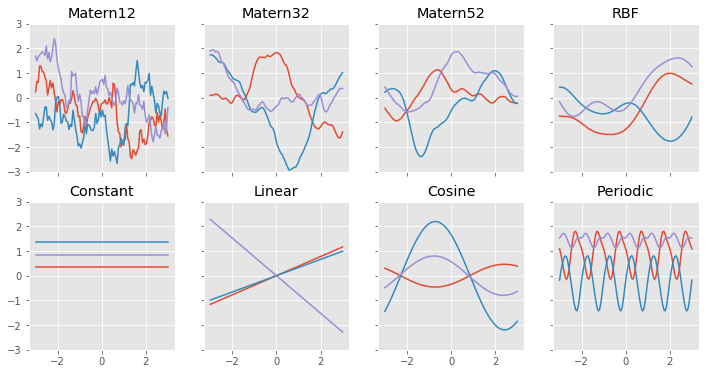

In [4]:
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(1), axes[0,0])
plotkernelsample(gpflow.kernels.Matern32(1), axes[0,1])
plotkernelsample(gpflow.kernels.Matern52(1), axes[0,2])
plotkernelsample(gpflow.kernels.RBF(1), axes[0,3])
plotkernelsample(gpflow.kernels.Constant(1), axes[1,0])
plotkernelsample(gpflow.kernels.Linear(1), axes[1,1])
plotkernelsample(gpflow.kernels.Cosine(1), axes[1,2])
plotkernelsample(gpflow.kernels.Periodic(1), axes[1,3])
axes[0,0].set_ylim(-3, 3)

### Combining kernels
Valid kernels can be made by adding and multiplying kernels. To do this in GPflow, you can add or multiply intances of kernels, which creates a new kernel with the parameters of the old ones. 

In [5]:
k1 = gpflow.kernels.Matern12(input_dim=1)
k2 = gpflow.kernels.Linear(input_dim=1)

k3 = k1 + k2
k4 = k1 * k2

### Kernels on multiple dimemensions
The first, obligatory argument to every kernel is *input_dim*, which in the above has been 1. to make a kernel which works on more inputs (columns of X), simply specify a different input_dim. 

Stationary kernels all have ARD options, which allows the user to have one lengthscale parameter per input. 

In [7]:
k = gpflow.kernels.Matern52(input_dim=5)
k.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
Matern52/variance,Parameter,None,+ve,True,(),True,1.0
Matern52/lengthscales,Parameter,None,+ve,True,(),True,1.0


In [8]:
k = gpflow.kernels.Matern52(input_dim=5, ARD=True)
k.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
Matern52/variance,Parameter,None,+ve,True,(),True,1.0
Matern52/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[1.0, 1.0, 1.0, 1.0, 1.0]"


### Active dimensions


When combining kernels, it's often helpful to have bits of the kernel working on different dimensions. For example, to model a function that is linear in the first dimension and smooth in the second, we could  use a combination of Linear and Matern52 kernels, one for each dimension. 

To tell GPflow which dimension a kernel applies to, one specifies the *active_dims*, which is a list of integers.

In [9]:
k1 = gpflow.kernels.Linear(1, active_dims=[0])
k2 = gpflow.kernels.Matern52(1, active_dims=[1])
k = k1 + k2

### Making new kernels

It's easy to make new kernels in GPflow. To demonstate, we'll have a look at the Brownian motion kernel, whose function is 
$$
k(x, x') = \sigma^2 \text{min}(x, x')
$$
where $\sigma^2$ is a variance parameter. 

In [10]:
import tensorflow as tf

class Brownian(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])
        self.variance = gpflow.Param(1.0, transform=gpflow.transforms.positive)
        
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.variance * tf.minimum(X, tf.transpose(X2))
    
    def Kdiag(self, X):
        return self.variance * tf.reshape(X, (-1,))

To make a new kernel class, we inherit form the base class `gpflow.kernels.Kernel` and implement three functions.

#### `__init__`
The constructor takes no argument in this simple case (though it could, if that was convenient). It *must* call the constructor of the super class with appropriate arguments. In this case, the input_dim is always 1 (Brownian motion is only defined in 1D) and we'll assume the active_dims are [0], for simplicity.

We've added a parameter to the kernel using the Param class. Using this class lets the parameter be used in computing the kernel function, and it will automatically be recognised for optimization (or MCMC). Here, the variance parameter is initialized at 1, and constrained to be positive. 

#### `K`
This is where you implement the kernel function itself. This takes two arguments, X and X2. By convention, we make the second argument optional (defaults to None). 

Inside K, all the computation must be done with tensorflow -- here we've used `tf.minimum`. When GPflow executes the `K` function, X, X2 and self.variance will be replaced with tensorflow tensors. 

#### `Kdiag`
This convenience function allows GPflow to save memory at predict time. It's simply the diagonal of the `K` function, in the case where X2 is None. It must return a 1D vector, so we use tensorflow's reshape command.

#### Using the kernel in a model

Because we've inherited from the `Kernel` base class, this new kernel has all the properties needed to be used in GPflow. It also has some convenience features such as

`k.compute_K(X, X2)`

Which allow the user to compute the kernel matrix using (and returning) numpy arrays. 

To show that this kernel works, let's use it inside GPregression. We'll see that Browninan motion has quite interesting properties. To add a little flexibility, we'll add a Constant kernel to our Brownian kernel, and the GPR class will handle the noise. 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 3.168990
  Number of iterations: 23
  Number of functions evaluations: 29


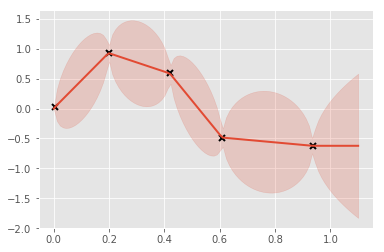

In [11]:
X = np.random.rand(5, 1)
Y = np.sin(X*6) + np.random.randn(*X.shape)*0.001


k1 = Brownian()
k2 = gpflow.kernels.Constant(1)
k = k1 + k2

m = gpflow.models.GPR(X, Y, kern=k)
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

xx = np.linspace(0, 1.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2)
line, = plt.plot(xx, mean, lw=2)
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)

The Brownian kernel can be displayed in the same way as the built-in kernels.

In [12]:
k1.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/brownian/variance,Parameter,None,+ve,True,(),True,2.20524323047342
